# Jenia Golbstein - Ellipse Detection

Download and extract dataset

In [1]:
%matplotlib inline
# here we load all relevant essential libraries/function/classes for the following code to run  
from utils_ellipse import *

Using TensorFlow backend.


In [2]:
dataset ='ellipse-dataset.tar.gz'

Ellipse_Instance = ellipse(dataset, from_url = False)

### Some data visualizations

In [3]:
df_train, df_test = Ellipse_Instance.read_metadata()
df_train.tail()

,center_x,center_y,angle,axis_1,axis_2,Training_images,is_ellipse
9995,0,0,0,0,0,images/train/9995.jpg,False
9996,30,22,321,6,10,images/train/9996.jpg,True
9997,19,26,342,10,14,images/train/9997.jpg,True
9998,31,17,52,17,21,images/train/9998.jpg,True
9999,27,34,194,23,12,images/train/9999.jpg,True


### Add normalized angle column
Convert angles to be in range of 0 to 179

In [5]:
df_train = Ellipse_Instance.add_normalized_angle(df_train)
df_test = Ellipse_Instance.add_normalized_angle(df_test)
df_train.tail()

,center_x,center_y,angle,axis_1,axis_2,Training_images,is_ellipse,angle_norm
9995,0,0,0,0,0,images/train/9995.jpg,False,0
9996,30,22,321,6,10,images/train/9996.jpg,True,141
9997,19,26,342,10,14,images/train/9997.jpg,True,162
9998,31,17,52,17,21,images/train/9998.jpg,True,52
9999,27,34,194,23,12,images/train/9999.jpg,True,14


### Set axis_1 > axis_2 and modify the angle accordingly

In [6]:
df_train = Ellipse_Instance.set_ax1_bigger_than_ax2(df_train)
df_test = Ellipse_Instance.set_ax1_bigger_than_ax2(df_test)
df_train.tail()

,center_x,center_y,angle,axis_1,axis_2,Training_images,is_ellipse,angle_norm,axis_1_new,axis_2_new,angle_norm_new
9995,0,0,0,0,0,images/train/9995.jpg,False,0,0,0,0
9996,30,22,321,6,10,images/train/9996.jpg,True,141,10,6,51
9997,19,26,342,10,14,images/train/9997.jpg,True,162,14,10,72
9998,31,17,52,17,21,images/train/9998.jpg,True,52,21,17,142
9999,27,34,194,23,12,images/train/9999.jpg,True,14,23,12,14


## Data distribution:

 is ellipse Training:
 Counter({'True': 6997, 'False': 3003})
 is ellipse Testing:
 Counter({'True': 688, 'False': 312})


Text(0.5,1,'Testing angles, 0 excluded')

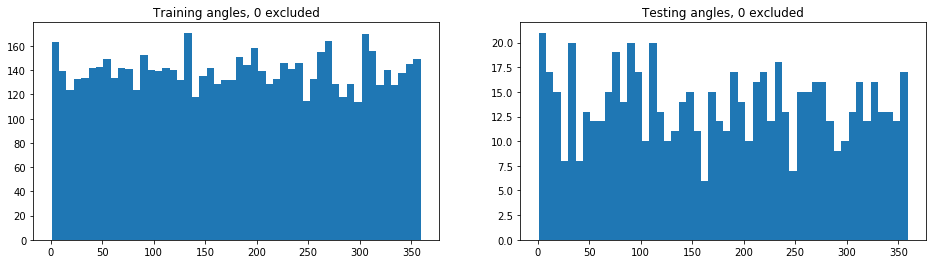

In [7]:
print(' is ellipse Training:\n',Counter(df_train["is_ellipse"]))
print(' is ellipse Testing:\n',Counter(df_test["is_ellipse"]))
test_angles = df_test["angle"].values
train_angles = df_train["angle"].values
f = plt.figure(figsize=(16,4))
f.add_subplot(121)
plt.hist(train_angles[train_angles>0], 50);
plt.title('Training angles, 0 excluded')
f.add_subplot(122)
plt.hist(test_angles[test_angles>0], 50);
plt.title('Testing angles, 0 excluded')

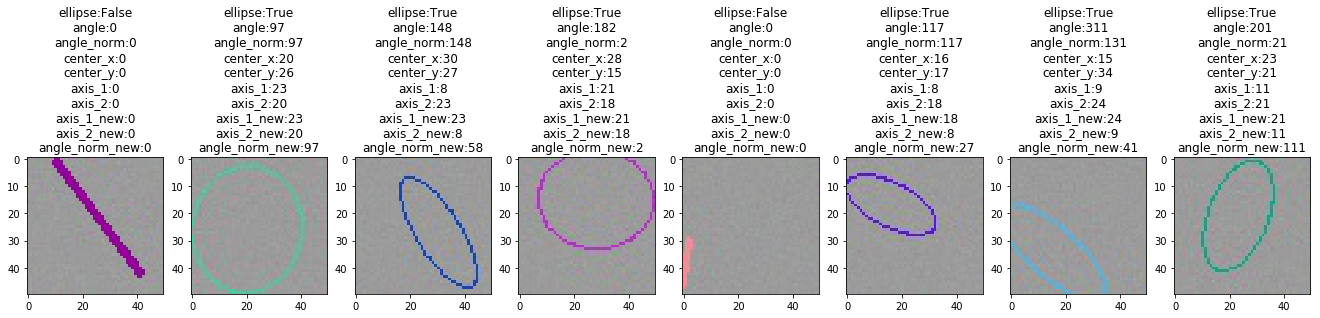

In [8]:
# plot sampled dataframe rows
plot_ellipse(df_train, 8, test=False)

### Loading images, features and labels

In [9]:
X_train, train_features, y_train = Ellipse_Instance.get_data(df_train, use_norm_feat = True)
X_test, test_features, y_test = Ellipse_Instance.get_data(df_test, use_norm_feat = True)

### Optional: image preprocessing, substracting backgroud and converting images to BW

155.0 155.0 155.0 +\- 12.864198 12.737656 12.884564


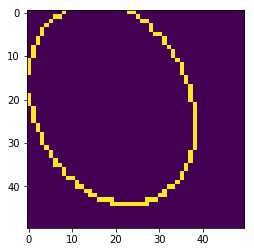

In [10]:
BW_train, BW_test = Ellipse_Instance.RGB2BW(X_train, X_test)
plt.imshow(BW_train[5555,:,:])

Our data now contains BW images as well as RGB images.

Let's preprocess the RGB images

In [11]:
X_train /= 255
X_test /= 255

# Building a DL model

In [19]:
bw_input_shape = np.prod(BW_train.shape[1:])
batch_size = 64
hm_epochs = 20
model = Ellipse_Instance.build_model(rgb_input_shape = X_train.shape[1:], 
                                     bw_input_shape = bw_input_shape, 
                                     feature_shape = train_features.shape[-1])

# flatten BW images
BW_test = BW_test.reshape([-1, bw_input_shape])
BW_train = BW_train.reshape([-1, bw_input_shape])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 50, 50, 3)    0                                            
__________________________________________________________________________________________________
first_conv (Conv2D)             (None, 50, 50, 32)   2432        input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_25 (BatchNo (None, 50, 50, 32)   128         first_conv[0][0]                 
__________________________________________________________________________________________________
second_conv (Conv2D)            (None, 46, 46, 32)   25632       batch_normalization_25[0][0]     
__________________________________________________________________________________________________
max_poolin

In [20]:
# Specify whether you want to use class weights since the data is imbalanced
# We don't really care of the features of the lines, we can set them to zero
# if is_ellipse=0, So we want to penalize more "mistakes" in features when the image IS an ellipse
# Therefore I've set the default to "false"

use_class_weights = False

if not use_class_weights:
    class_weights = {0: 1., 1: 1.}
else:
    from sklearn.utils import class_weight
    class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
    class_weights = {class_id : w for class_id, w in enumerate(class_weights)}    

print(class_weights)

{0: 1.0, 1: 1.0}


### Train the model!

In [21]:
model.compile(Adam(), loss=['mse', 'binary_crossentropy'], metrics=['accuracy'],
             loss_weights=[.001, 1.])
## callbacks:
modelpath = 'ellipse_model.h5'
checkpointer = ModelCheckpoint(filepath=modelpath, verbose=0, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_features_loss', factor=0.5, patience=2, min_lr=0.00001)
callbacks = [checkpointer, reduce_lr]

history = model.fit([BW_train, X_train], [train_features, y_train], batch_size=batch_size, 
                             epochs=hm_epochs, verbose=1, validation_split=0.4, callbacks = callbacks,
                             shuffle=True, class_weight=class_weights)

Train on 6000 samples, validate on 4000 samples
Epoch 1/20
6000/6000 [==============================] - 13s 2ms/step - loss: 1.4504 - features_loss: 1346.6620 - ellipse_loss: 0.1038 - features_acc: 0.4937 - ellipse_acc: 0.9605 - val_loss: 14.2627 - val_features_loss: 3128.8609 - val_ellipse_loss: 11.1338 - val_features_acc: 0.0022 - val_ellipse_acc: 0.2973
Epoch 2/20
6000/6000 [==============================] - 7s 1ms/step - loss: 0.9774 - features_loss: 931.4950 - ellipse_loss: 0.0459 - features_acc: 0.4703 - ellipse_acc: 0.9850 - val_loss: 20.0173 - val_features_loss: 8662.0624 - val_ellipse_loss: 11.3552 - val_features_acc: 0.0000e+00 - val_ellipse_acc: 0.2955
Epoch 3/20
6000/6000 [==============================] - 7s 1ms/step - loss: 0.5761 - features_loss: 542.4648 - ellipse_loss: 0.0337 - features_acc: 0.5153 - ellipse_acc: 0.9887 - val_loss: 12.0877 - val_features_loss: 2570.0684 - val_ellipse_loss: 9.5177 - val_features_acc: 0.0440 - val_ellipse_acc: 0.3232
Epoch 4/20
6000/6000

Plot training progress

(0.3, 1.1)

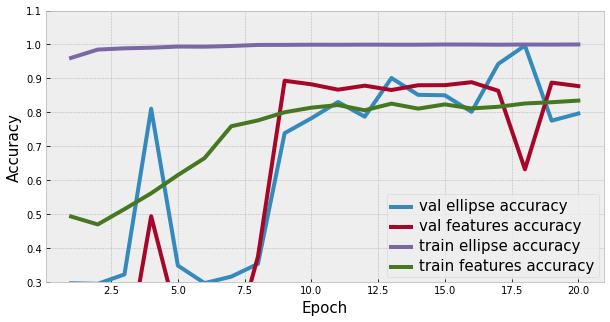

In [23]:
style.use('bmh')
epochs = list(range(1, hm_epochs+1))
val_ellipse_acc = history.history['val_ellipse_acc']
val_features_acc = history.history['val_features_acc']
ellipse_acc = history.history['ellipse_acc']
features_acc = history.history['features_acc']

f = plt.figure(figsize=(10,5));
plt.plot(epochs, val_ellipse_acc, linewidth=4)
plt.plot(epochs, val_features_acc, linewidth=4)
plt.plot(epochs, ellipse_acc, linewidth=4)
plt.plot(epochs, features_acc, linewidth=4)
plt.xlabel('Epoch',fontsize=15), plt.ylabel('Accuracy',fontsize=15)
legend = plt.legend(('val ellipse accuracy', 'val features accuracy', 'train ellipse accuracy', 'train features accuracy'))
plt.setp(legend.get_texts(), color='k', fontsize=15);
plt.ylim((0.3,1.1))

### Evaluate model

In [24]:
model.load_weights(modelpath)
loss,feat_loss,ellip_loss,feat_acc,ellip_acc = model.evaluate([BW_test, X_test], [test_features, y_test])
print('Test Ellipse Accuracy', ellip_acc)
print('Test Feature Accuracy', feat_acc)

1000/1000 [==============================] - 0s 436us/step
Test Ellipse Accuracy 0.996
Test Feature Accuracy 0.62


## Plot Confusion Matrix For Test Ellipse Classification

1000/1000 [==============================] - 1s 532us/step


Text(0.5,4.97309,'Predicted label')

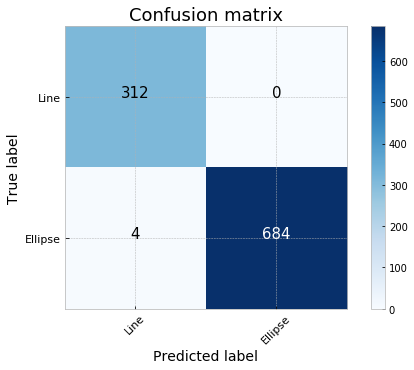

In [25]:
preds = model.predict([BW_test, X_test], verbose=1, batch_size=batch_size)
preds_y = (preds[1].flatten()>0.5).astype(float);
plt.figure(figsize=(7,5))

cm = confusion_matrix(y_test, preds_y)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix', fontsize=18)
classes = ['Line', 'Ellipse']
plt.colorbar()
tick_marks = np.arange(len(classes));
plt.xticks(tick_marks, classes, rotation=45,fontsize=11)
plt.yticks(tick_marks, classes,fontsize=11)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black", fontsize=15)

plt.tight_layout()
plt.ylabel('True label',fontsize=14)
plt.xlabel('Predicted label',fontsize=14)


Evaluate predicted ellipse features

In [29]:
pred_features = np.round(preds[0])
pred_features[pred_features<0] = 0
df = pd.DataFrame()
df['angle'] = pred_features[:,0]
df['center_x'] = pred_features[:,1]
df['center_y'] = pred_features[:,2]
df['axis_1'] = pred_features[:,3]
df['axis_2'] = pred_features[:,4]
df['is_ellipse'] = np.bool8(preds_y)
df['Testing_images'] = df_test["Testing_images"].values
df.to_csv('prediction.csv')
df.head()

,angle,center_x,center_y,axis_1,axis_2,is_ellipse,Testing_images
0,75.0,32.0,24.0,21.0,15.0,True,images/test/0000.jpg
1,73.0,21.0,27.0,16.0,17.0,True,images/test/0001.jpg
2,0.0,0.0,1.0,0.0,0.0,False,images/test/0002.jpg
3,134.0,28.0,33.0,6.0,4.0,True,images/test/0003.jpg
4,0.0,1.0,0.0,0.0,-0.0,False,images/test/0004.jpg


(Text(0.5,0,'True normalized axis_2'),
 Text(0,0.5,'Predicted normalized axis_2'))

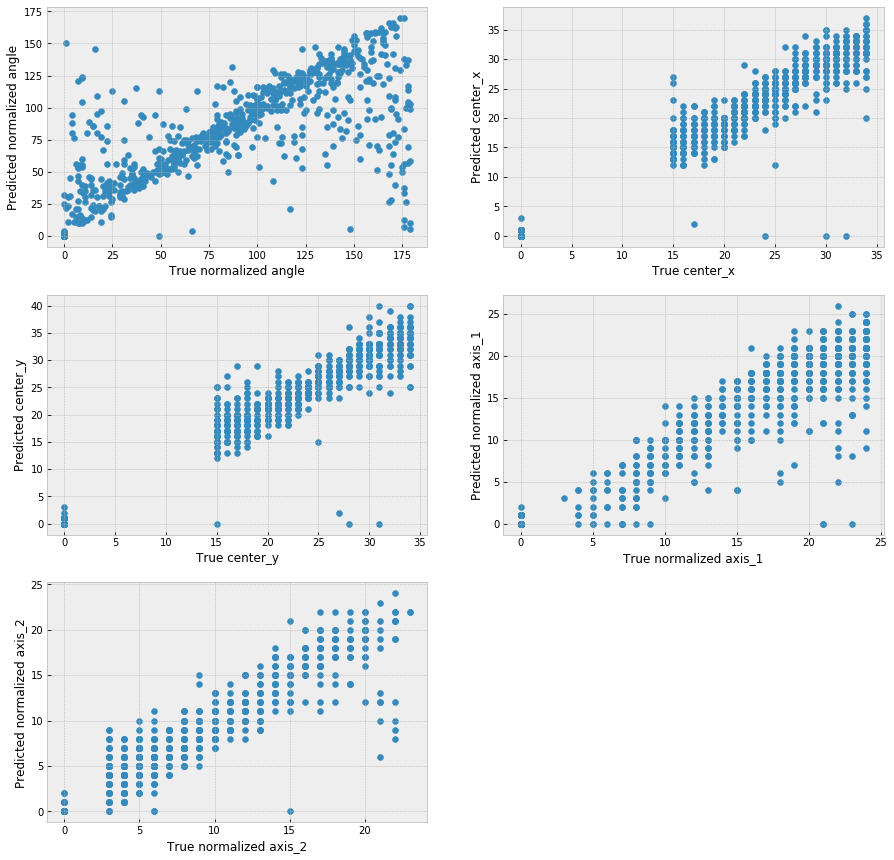

In [30]:
f = plt.figure(figsize=(15,15))
f.add_subplot(321)
plt.scatter(test_features[:,0], pred_features[:,0])
plt.xlabel('True normalized angle'), plt.ylabel('Predicted normalized angle')
f.add_subplot(322)
plt.scatter(test_features[:,1], pred_features[:,1])
plt.xlabel('True center_x'), plt.ylabel('Predicted center_x')
f.add_subplot(323)
plt.scatter(test_features[:,2], pred_features[:,2])
plt.xlabel('True center_y'), plt.ylabel('Predicted center_y')
f.add_subplot(324)
plt.scatter(test_features[:,3], pred_features[:,3])
plt.xlabel('True normalized axis_1'), plt.ylabel('Predicted normalized axis_1')
f.add_subplot(325)
plt.scatter(test_features[:,4], pred_features[:,4])
plt.xlabel('True normalized axis_2'), plt.ylabel('Predicted normalized axis_2')